In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
df = pd.read_csv("Master_price_dataset_.csv")
df.head()


,Date,Year,Category,Product Name,Price (INR),Platform
0,2019-01,2019,Electronics,Air Conditioner,38000,Flipkart
1,2019-01,2019,Electronics,Air Conditioner,38000,Amazon
2,2019-02,2019,Electronics,Air Conditioner,38000,Flipkart
3,2019-02,2019,Electronics,Air Conditioner,38000,Amazon
4,2019-03,2019,Electronics,Air Conditioner,38000,Flipkart


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23112 entries, 0 to 23111
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          23112 non-null  object
 1   Year          23112 non-null  int64 
 2   Category      23112 non-null  object
 3   Product Name  23112 non-null  object
 4   Price (INR)   23112 non-null  int64 
 5   Platform      23112 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])


In [6]:
df = df.sort_values(
    by=['Category', 'Product Name', 'Platform', 'Date']
)


In [7]:
product_df = df[
    (df['Product Name'] == 'Xiaomi Redmi 10') &
    (df['Platform'] == 'Flipkart')
].copy()

product_df.head()


,Date,Year,Category,Product Name,Price (INR),Platform
20088,2019-01-01,2019,Smartphones,Xiaomi Redmi 10,8699,Flipkart
20089,2019-02-01,2019,Smartphones,Xiaomi Redmi 10,8699,Flipkart
20090,2019-03-01,2019,Smartphones,Xiaomi Redmi 10,8699,Flipkart
20091,2019-04-01,2019,Smartphones,Xiaomi Redmi 10,8699,Flipkart
20092,2019-05-01,2019,Smartphones,Xiaomi Redmi 10,8699,Flipkart


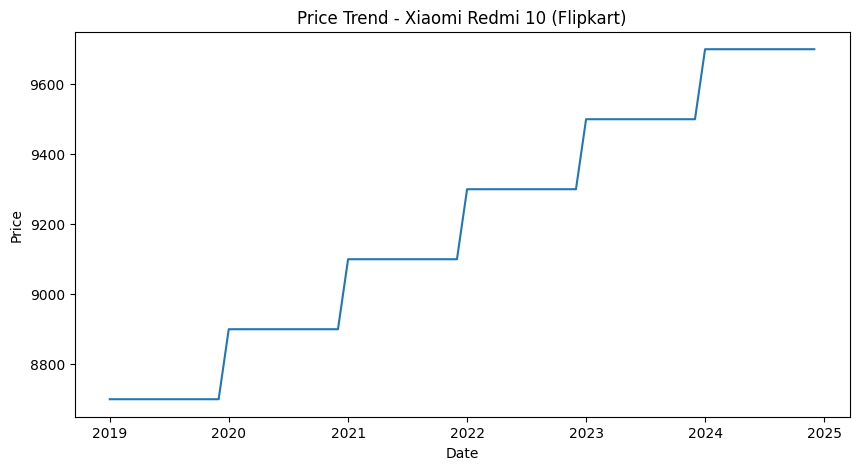

In [9]:
plt.figure(figsize=(10,5))
plt.plot(product_df['Date'], product_df['Price (INR)'])
plt.title("Price Trend - Xiaomi Redmi 10 (Flipkart)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [10]:
# Make sure data is sorted
product_df = product_df.sort_values('Date').reset_index(drop=True)

# Extract price & date properly
prices = product_df['Price (INR)'].values.reshape(-1, 1)
dates  = product_df['Date'].values


In [11]:
def create_sequences_with_dates(data, dates, window_size=6):
    X, y = [], []
    X_dates, y_dates = [], []

    for i in range(len(data) - window_size):
        # Input: last 6 months prices
        X.append(data[i:i+window_size])
        # Output: next month price
        y.append(data[i+window_size])

        # Correct variable names
        X_dates.append(dates[i:i+window_size])
        y_dates.append(dates[i+window_size])

    return (
        np.array(X),
        np.array(y),
        np.array(X_dates),
        np.array(y_dates)
    )


In [12]:
prices = product_df['Price (INR)'].values.reshape(-1, 1)


In [13]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)


In [14]:
X, y, X_dates, y_dates = create_sequences_with_dates(
    scaled_prices, dates, window_size=6
)

X.shape, y.shape


((66, 6, 1), (66, 1))

In [15]:
sample = 0

print("INPUT (Last 6 months):")
for d, p in zip(X_dates[sample], prices[sample:sample+6]):
    print(pd.to_datetime(d).strftime("%Y-%m"), "→", p[0])

print("\nOUTPUT (Next month):")
print(
    pd.to_datetime(y_dates[sample]).strftime("%Y-%m"),
    "→",
    prices[sample+6][0]
)


INPUT (Last 6 months):
2019-01 → 8699
2019-02 → 8699
2019-03 → 8699
2019-04 → 8699
2019-05 → 8699
2019-06 → 8699

OUTPUT (Next month):
2019-07 → 8699


In [16]:
# 80% train, 20% test
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test  = X[train_size:]

y_train = y[:train_size]
y_test  = y[train_size:]

X_train.shape, X_test.shape


((52, 6, 1), (14, 6, 1))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(
    units=50,
    activation='relu',
    input_shape=(X_train.shape[1], 1)
))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.2249 - val_loss: 0.7681
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1970 - val_loss: 0.6385
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1370 - val_loss: 0.5014
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1280 - val_loss: 0.3404
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0703 - val_loss: 0.1725
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0338 - val_loss: 0.0384
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - val_loss: 0.0050
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - val_loss: 0.0051
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - val_loss: 0.0108
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 0.0084
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0081
E

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on test data
predicted = model.predict(X_test)

# Inverse scaling
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print("MAE:", mae)
print("RMSE:", rmse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
MAE: 64.65018136160714
RMSE: 73.2238161357772


In [20]:
# Last 6 months data
last_6_months = scaled_prices[-6:]
last_6_months = last_6_months.reshape(1, 6, 1)

next_month_scaled = model.predict(last_6_months)
next_month_price = scaler.inverse_transform(next_month_scaled)

print("Predicted Next Month Price:", int(next_month_price[0][0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicted Next Month Price: 9768


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [22]:
df = pd.read_csv("Master_price_dataset_.csv")
df.head()


,Date,Year,Category,Product Name,Price (INR),Platform
0,2019-01,2019,Electronics,Air Conditioner,38000,Flipkart
1,2019-01,2019,Electronics,Air Conditioner,38000,Amazon
2,2019-02,2019,Electronics,Air Conditioner,38000,Flipkart
3,2019-02,2019,Electronics,Air Conditioner,38000,Amazon
4,2019-03,2019,Electronics,Air Conditioner,38000,Flipkart


In [23]:
product_df = df[
    (df['Product Name'] == 'Xiaomi Redmi 10') &
    (df['Platform'] == 'Flipkart')
].copy()


In [24]:
prices = product_df['Price (INR)'].values.reshape(-1, 1)


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)


In [26]:
df['Date'] = pd.to_datetime(df['Date'])

In [27]:
future_prices = []
future_months = []

# LAST 6 REAL months (dataset-la irukkura last months)
current_sequence = scaled_prices[-6:].reshape(1, 6, 1)

# LAST REAL date
current_date = pd.to_datetime(product_df['Date'].iloc[-1])


In [28]:
def create_sequences(data, window_size=6):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_prices, window_size=6)
X.shape, y.shape


((66, 6, 1), (66, 1))

In [ ]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test  = X[train_size:]

y_train = y[:train_size]
y_test  = y[train_size:]

X_train.shape, X_test.shape


((52, 6, 1), (14, 6, 1))

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1698 - val_loss: 0.4866
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1091 - val_loss: 0.2988
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0644 - val_loss: 0.1320
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0221 - val_loss: 0.0270
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112 - val_loss: 0.0059
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - val_loss: 0.0119
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0053
E

In [30]:
future_prices = []
future_months = []

current_sequence = scaled_prices[-6:].reshape(1, 6, 1)
current_date = pd.to_datetime(product_df['Date'].iloc[-1])

for _ in range(6):
    next_scaled = model.predict(current_sequence, verbose=0)
    next_price  = scaler.inverse_transform(next_scaled)[0][0]

    future_prices.append(next_price)

    current_date += pd.DateOffset(months=1)
    future_months.append(current_date)

    current_sequence = np.append(
        current_sequence[:, 1:, :],
        next_scaled.reshape(1, 1, 1),
        axis=1
    )

future_df = pd.DataFrame({
    'Month': pd.to_datetime(future_months).strftime('%Y-%m'),
    'Predicted Price': future_prices
})

best_row = future_df.loc[future_df['Predicted Price'].idxmin()]
future_df, best_row


(     Month  Predicted Price
 0  2025-01      9758.148438
 1  2025-02      9771.477539
 2  2025-03      9787.019531
 3  2025-04      9805.189453
 4  2025-05      9825.686523
 5  2025-06      9849.712891,
 Month                  2025-01
 Predicted Price    9758.148438
 Name: 0, dtype: object)

In [31]:
model.save("price_lstm_model.h5")
print("Model saved successfully")


Model saved successfully


In [32]:
future_df['Predicted Price'] = future_df['Predicted Price'].round().astype(int)
future_df


,Month,Predicted Price
0,2025-01,9758
1,2025-02,9771
2,2025-03,9787
3,2025-04,9805
4,2025-05,9826
5,2025-06,9850


In [33]:
best_row = future_df.loc[future_df['Predicted Price'].idxmin()]

best_month = best_row['Month']
best_price = best_row['Predicted Price']


In [34]:
print(" BEST MONTH TO BUY ")
print("----------------------")
print("📆 Month :", best_month)
print("💰 Expected Price : ₹", best_price)


 BEST MONTH TO BUY 
----------------------
📆 Month : 2025-01
💰 Expected Price : ₹ 9758


In [35]:
def highlight_best(row):
    if row['Month'] == best_month:
        return ['background-color: lightgreen'] * len(row)
    else:
        return [''] * len(row)

future_df.style.apply(highlight_best, axis=1)


,Month,Predicted Price
0,2025-01,9758
1,2025-02,9771
2,2025-03,9787
3,2025-04,9805
4,2025-05,9826
5,2025-06,9850


In [36]:
# ================= SMART PURCHASE RECOMMENDATION =================

# 1️⃣ Clean predicted prices (remove decimals)
future_df['Predicted Price'] = future_df['Predicted Price'].round().astype(int)

# 2️⃣ Identify BEST MONTH TO BUY (lowest predicted price)
best_row = future_df.loc[future_df['Predicted Price'].idxmin()]

best_month = best_row['Month']
best_price = int(best_row['Predicted Price'])

# 3️⃣ Last actual price from dataset
last_price = int(product_df['Price (INR)'].iloc[-1])

# 4️⃣ Product name
product_name = product_df['Product Name'].iloc[0]

# 5️⃣ SMART RECOMMENDATION LOGIC
if best_price > last_price:
    recommendation = "✅ Buy Now – Price likely to increase"
elif best_price < last_price:
    recommendation = "⏳ Wait – Better price expected"
else:
    recommendation = "📆 Buy in Best Month – Stable price"

# 6️⃣ FINAL OUTPUT (REVIEW READY)
print("\n📦 SMART PURCHASE RECOMMENDATION")
print("-" * 50)
print("Product              :", product_name)
print("Last Actual Price    : ₹", last_price)
print("Best Predicted Price : ₹", best_price)
print("Best Month to Buy    :", best_month)
print("Recommendation       :", recommendation)
print("-" * 50)



📦 SMART PURCHASE RECOMMENDATION
--------------------------------------------------
Product              : Xiaomi Redmi 10
Last Actual Price    : ₹ 9699
Best Predicted Price : ₹ 9758
Best Month to Buy    : 2025-01
Recommendation       : ✅ Buy Now – Price likely to increase
--------------------------------------------------


In [37]:
smartphone_df = df[df['Category'] == 'Smartphones'].copy()
smartphone_df['Date'] = pd.to_datetime(smartphone_df['Date'])
smartphone_df = smartphone_df.sort_values(['Product Name', 'Date']).reset_index(drop=True)


In [38]:
smartphone_df['Product Name'].unique()


array(['Apple Iphone 11', 'Apple Iphone 12', 'Apple Iphone 12 Mini',
       'Apple Iphone 13', 'Apple Iphone 13 Pro', 'Apple Iphone 14',
       'Apple Iphone 14 Plus', 'Apple Iphone 14 Pro',
       'Apple Iphone 14 Pro Max', 'Google Pixel 6A', 'Google Pixel 7',
       'I Kall I Kall 401 Pro Dark Blue', 'I Kall I Kall Z19Pro',
       'I Kall I Kall Z20 Pro', 'I Kall I Kall Z5', 'Infinix Hot 11',
       'Infinix Hot 11 2022', 'Infinix Hot 11S', 'Infinix Hot 12',
       'Infinix Hot 12 Play', 'Infinix Hot 12 Pro', 'Infinix Hot 20 5G',
       'Infinix Hot 20 Play', 'Infinix Note 11', 'Infinix Note 11S',
       'Infinix Note 12', 'Infinix Note 12 5G', 'Infinix Note 12 Pro',
       'Infinix Note 12 Pro 5G', 'Infinix Note 12 Turbo',
       'Infinix Note 12I', 'Infinix Smart 5A', 'Infinix Smart 6',
       'Infinix Smart 6 Hd', 'Infinix Smart 6 Plus',
       'Infinix Smart Hd 2021', 'Infinix Zero 20', 'Infinix Zero 5G',
       'Infinix Zero 5G 2023', 'Infinix Zero 5G 2023 Turbo', 'Iqoo 9T 5G',


In [39]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

WINDOW = 2

X_all, y_all = [], []

for product in smartphone_df['Product Name'].unique():

    product_data = smartphone_df[smartphone_df['Product Name'] == product]

    if len(product_data) < WINDOW + 1:
        continue

    prices = product_data['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    for i in range(len(scaled_prices) - WINDOW):
        X_all.append(scaled_prices[i:i+WINDOW])
        y_all.append(scaled_prices[i+WINDOW])

X = np.array(X_all)
y = np.array(y_all)

X.shape, y.shape


((21210, 2, 1), (21210, 1))

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(WINDOW, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(
    X, y,
    epochs=30,
    batch_size=8,
    verbose=1
)


Epoch 1/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0361
Epoch 2/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0031
Epoch 3/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0028
Epoch 4/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0027
Epoch 5/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0027
Epoch 6/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0026
Epoch 7/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0027
Epoch 8/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0027
Epoch 9/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0027
Epoch 10/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0026
Epoch 11/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0026
Epoch 12/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0027
Epoch 13/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0027
Epoch 14/30
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0025
Epoch 15/30
2652/2652 ━━━━━━━

In [42]:
samsung_df = smartphone_df[smartphone_df['Product Name'] == 'Samsung Galaxy F22']

last_prices = samsung_df['Price (INR)'].values[-WINDOW:].reshape(-1, 1)
last_scaled = scaler.fit_transform(last_prices).reshape(1, WINDOW, 1)

pred_scaled = model.predict(last_scaled)
pred_price = scaler.inverse_transform(pred_scaled)

int(pred_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


11899

In [43]:
def smart_recommendation(product_name, n_future=3):

    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler

    # Filter product data
    product_df = smartphone_df[smartphone_df['Product Name'] == product_name].copy()

    if len(product_df) < WINDOW + 1:
        print("❌ Not enough data for prediction")
        return

    product_df = product_df.sort_values('Date')

    last_actual_price = int(product_df['Price (INR)'].iloc[-1])
    last_date = pd.to_datetime(product_df['Date'].iloc[-1])

    # Prepare input
    last_prices = product_df['Price (INR)'].values[-WINDOW:].reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_last = scaler.fit_transform(last_prices)

    current_seq = scaled_last.reshape(1, WINDOW, 1)
    current_date = last_date

    future_prices = []
    future_months = []

    # Predict future prices
    for _ in range(n_future):
        next_scaled = model.predict(current_seq, verbose=0)
        next_price = int(scaler.inverse_transform(next_scaled)[0][0])

        future_prices.append(next_price)

        current_date += pd.DateOffset(months=1)
        future_months.append(current_date.strftime("%Y-%m"))

        current_seq = np.append(
            current_seq[:, 1:, :],
            next_scaled.reshape(1, 1, 1),
            axis=1
        )

    # Best month logic
    best_index = np.argmin(future_prices)
    best_month = future_months[best_index]
    best_price = future_prices[best_index]

    # Recommendation logic
    if best_price < last_actual_price:
        recommendation = "⏳ Wait – Better price expected"
    elif best_price > last_actual_price:
        recommendation = "✅ Buy Now – Price likely to increase"
    else:
        recommendation = "📆 Buy in Best Month – Stable price"

    # Final output
    print("\n📦 SMART PURCHASE RECOMMENDATION")
    print("-" * 55)
    print("Product            :", product_name)
    print("Last Actual Price  : ₹", last_actual_price)
    print("Future Predictions :", future_prices)
    print("Best Month to Buy  :", best_month)
    print("Expected Price    : ₹", best_price)
    print("Recommendation    :", recommendation)
    print("-" * 55)


In [44]:
smart_recommendation("Realme Narzo 30 Pro 5G")



📦 SMART PURCHASE RECOMMENDATION
-------------------------------------------------------
Product            : Realme Narzo 30 Pro 5G
Last Actual Price  : ₹ 20399
Future Predictions : [20399, 20399, 20399]
Best Month to Buy  : 2025-01
Expected Price    : ₹ 20399
Recommendation    : 📆 Buy in Best Month – Stable price
-------------------------------------------------------


In [45]:
smartphone_df.groupby('Product Name').size()


,0
Product Name,
Apple Iphone 11,72
Apple Iphone 12,72
Apple Iphone 12 Mini,72
Apple Iphone 13,72
Apple Iphone 13 Pro,72
...,...
Xiaomi Redmi Note 12 Pro+ 5G,72
Xiaomi Redmi Note 5 Pro,72
Xiaomi Redmi Note 7S,72


In [46]:
def smart_recommendation(product_name, n_future=3):

    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler

    product_df = smartphone_df[smartphone_df['Product Name'] == product_name].copy()

    if len(product_df) < WINDOW + 1:
        print(f"❌ '{product_name}' Not enough for prediction")
        return

    product_df = product_df.sort_values('Date')

    last_actual_price = int(product_df['Price (INR)'].iloc[-1])
    last_date = pd.to_datetime(product_df['Date'].iloc[-1])

    last_prices = product_df['Price (INR)'].values[-WINDOW:].reshape(-1,1)

    scaler = MinMaxScaler()
    scaled_last = scaler.fit_transform(last_prices)

    current_seq = scaled_last.reshape(1, WINDOW, 1)
    current_date = last_date

    future_prices = []
    future_months = []

    for _ in range(n_future):
        next_scaled = model.predict(current_seq, verbose=0)
        next_price = int(scaler.inverse_transform(next_scaled)[0][0])

        future_prices.append(next_price)

        current_date += pd.DateOffset(months=1)
        future_months.append(current_date.strftime("%Y-%m"))

        current_seq = np.append(
            current_seq[:, 1:, :],
            next_scaled.reshape(1, 1, 1),
            axis=1
        )

    # LATEST prediction only
    latest_month = future_months[-1]
    latest_price = future_prices[-1]

    # Best month logic (still based on all predictions)
    best_index = np.argmin(future_prices)
    best_month = future_months[best_index]
    best_price = future_prices[best_index]

    # Recommendation
    if best_price < last_actual_price:
        recommendation = "⏳ Wait – Better price expected"
    elif best_price > last_actual_price:
        recommendation = "✅ Buy Now – Price likely to increase"
    else:
        recommendation = "📆 Buy in Best Month – Stable price"

    # FINAL OUTPUT
    print("\n📦 SMART PURCHASE RECOMMENDATION ")
    print("-" * 60)
    print("Product                 :", product_name)
    print("Last Actual Price       : ₹", last_actual_price)
    print("Latest Predicted Month  :", latest_month)
    print("Predicted Price         : ₹", latest_price)
    print("Best Month to Buy       :", best_month)
    print("Recommendation          :", recommendation)
    print("-" * 60)


In [47]:
smart_recommendation("Xiaomi Redmi Note 9 Pro")


📦 SMART PURCHASE RECOMMENDATION 
------------------------------------------------------------
Product                 : Xiaomi Redmi Note 9 Pro
Last Actual Price       : ₹ 14850
Latest Predicted Month  : 2025-03
Predicted Price         : ₹ 14850
Best Month to Buy       : 2025-01
Recommendation          : 📆 Buy in Best Month – Stable price
------------------------------------------------------------


In [48]:
def smart_recommendation(product_name):

    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler

    product_df = smartphone_df[smartphone_df['Product Name'] == product_name].copy()

    if len(product_df) < WINDOW + 1:
        print(f"❌ '{product_name}' Not enough for prediction")
        return

    product_df = product_df.sort_values('Date')

    last_actual_price = int(product_df['Price (INR)'].iloc[-1])
    last_date = pd.to_datetime(product_df['Date'].iloc[-1])

    last_prices = product_df['Price (INR)'].values[-WINDOW:].reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_last = scaler.fit_transform(last_prices)

    current_seq = scaled_last.reshape(1, WINDOW, 1)
    current_date = last_date

    future_prices = []
    future_months = []

    # 🔁 predict till end of 2026 (24 months safe)
    for _ in range(24):
        next_scaled = model.predict(current_seq, verbose=0)
        next_price = int(scaler.inverse_transform(next_scaled)[0][0])

        current_date += pd.DateOffset(months=1)

        future_prices.append(next_price)
        future_months.append(current_date.strftime("%Y-%m"))

        current_seq = np.append(
            current_seq[:, 1:, :],
            next_scaled.reshape(1, 1, 1),
            axis=1
        )

    # 👉 TAKE ONLY 2026 DATA
    future_2026_prices = [
        p for m, p in zip(future_months, future_prices) if m.startswith("2026")
    ]
    future_2026_months = [
        m for m in future_months if m.startswith("2026")
    ]

    # Use first 3 months (same style as before)
    display_prices = future_2026_prices[:3]
    display_months = future_2026_months[:3]

    best_index = np.argmin(display_prices)
    best_month = display_months[best_index]
    best_price = display_prices[best_index]

    # Recommendation logic
    if best_price < last_actual_price:
        recommendation = "⏳ Wait – Better price expected"
    elif best_price > last_actual_price:
        recommendation = "✅ Buy Now – Price likely to increase"
    else:
        recommendation = "📆 Buy in Best Month – Stable price"

    # ✅ FINAL OUTPUT (SAME FORMAT)
    print("\n📦 SMART PURCHASE RECOMMENDATION")
    print("-" * 55)
    print("Product            :", product_name)
    print("Last Actual Price  : ₹", last_actual_price)
    print("Future Predictions :", display_prices)
    print("Best Month to Buy  :", best_month)
    print("Expected Price    : ₹", best_price)
    print("Recommendation    :", recommendation)
    print("-" * 55)


In [49]:
smart_recommendation("Realme Narzo 30 Pro 5G")


📦 SMART PURCHASE RECOMMENDATION
-------------------------------------------------------
Product            : Realme Narzo 30 Pro 5G
Last Actual Price  : ₹ 20399
Future Predictions : [20399, 20399, 20399]
Best Month to Buy  : 2026-01
Expected Price    : ₹ 20399
Recommendation    : 📆 Buy in Best Month – Stable price
-------------------------------------------------------


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def backtesting_error_metrics(product_name):

    product_df = smartphone_df[smartphone_df['Product Name'] == product_name].copy()
    product_df = product_df.sort_values('Date').reset_index(drop=True)

    prices = product_df['Price (INR)'].values
    dates = pd.to_datetime(product_df['Date'])

    actuals = []
    predictions = []

    for i in range(WINDOW, len(prices)-1):
        # past WINDOW prices
        past_prices = prices[i-WINDOW:i].reshape(-1, 1)

        scaler = MinMaxScaler()
        scaled_past = scaler.fit_transform(past_prices)

        X_input = scaled_past.reshape(1, WINDOW, 1)

        pred_scaled = model.predict(X_input, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled)[0][0]

        predictions.append(pred_price)
        actuals.append(prices[i])

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))

    print("\n📊 BACKTESTING ERROR METRICS ")
    print("-" * 60)
    print("Product :", product_name)
    print("MAE     : ₹", round(mae, 2))
    print("RMSE    : ₹", round(rmse, 2))
    print("-" * 60)


In [51]:
backtesting_error_metrics("Realme Narzo 30 Pro 5G")



📊 BACKTESTING ERROR METRICS 
------------------------------------------------------------
Product : Realme Narzo 30 Pro 5G
MAE     : ₹ 17.52
RMSE    : ₹ 54.98
------------------------------------------------------------


In [52]:
import ipywidgets as widgets
from IPython.display import display, clear_output


In [53]:
category_dropdown = widgets.Dropdown(
    options=sorted(df['Category'].dropna().unique()),
    description='Category:',
    style={'description_width': 'initial'}
)


In [54]:
product_dropdown = widgets.Dropdown(
    options=[],
    description='Product:',
    style={'description_width': 'initial'}
)


In [55]:
def update_products(change):
    selected_category = change['new']

    products = (
        df[df['Category'] == selected_category]['Product Name']
        .dropna()
        .unique()
        .tolist()
    )

    product_dropdown.options = sorted(products)


In [56]:
def show_prediction(change):
    selected_product = change['new']
    print("\n🔍 Running prediction for:", selected_product)
    smart_recommendation(selected_product)

    # 🔥 important: initial trigger
update_products({'new': category_dropdown.value})


In [57]:
product_dropdown.observe(show_prediction, names='value')


In [58]:
product_df = smartphone_df[smartphone_df['Product Name'] == product_name]

print(df[df['Product Name'] == "Apple Iphone 12"])
print(smartphone_df['Product Name'].unique())




          Date  Year     Category     Product Name  Price (INR)  Platform
216 2019-01-01  2019  Smartphones  Apple Iphone 12        51399  Flipkart
217 2019-02-01  2019  Smartphones  Apple Iphone 12        51399  Flipkart
218 2019-03-01  2019  Smartphones  Apple Iphone 12        51399  Flipkart
219 2019-04-01  2019  Smartphones  Apple Iphone 12        51399  Flipkart
220 2019-05-01  2019  Smartphones  Apple Iphone 12        51399  Flipkart
..         ...   ...          ...              ...          ...       ...
283 2024-08-01  2024  Smartphones  Apple Iphone 12        52399  Flipkart
284 2024-09-01  2024  Smartphones  Apple Iphone 12        52399  Flipkart
285 2024-10-01  2024  Smartphones  Apple Iphone 12        52399  Flipkart
286 2024-11-01  2024  Smartphones  Apple Iphone 12        52399  Flipkart
287 2024-12-01  2024  Smartphones  Apple Iphone 12        52399  Flipkart

[72 rows x 6 columns]
['Apple Iphone 11' 'Apple Iphone 12' 'Apple Iphone 12 Mini'
 'Apple Iphone 13' 'Apple Iph

In [59]:
def smart_recommendation(product_name):



    #  USE MAIN DATAFRAME
    product_df = df[df['Product Name'] == product_name].copy()

    if len(product_df) < WINDOW + 1:
        print("❌ Not enough data for prediction")
        return

    product_df = product_df.sort_values('Date')

    last_actual_price = int(product_df['Price (INR)'].iloc[-1])
    last_date = pd.to_datetime(product_df['Date'].iloc[-1])

    last_prices = product_df['Price (INR)'].values[-WINDOW:].reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_last = scaler.fit_transform(last_prices)

    current_seq = scaled_last.reshape(1, WINDOW, 1)
    current_date = last_date

    future_prices = []
    future_months = []

    # 🔁 Predict next 24 months (to reach 2026)
    for _ in range(24):
        next_scaled = model.predict(current_seq, verbose=0)
        next_price = int(scaler.inverse_transform(next_scaled)[0][0])

        current_date += pd.DateOffset(months=1)

        future_prices.append(next_price)
        future_months.append(current_date.strftime("%Y-%m"))

        current_seq = np.append(
            current_seq[:, 1:, :],
            next_scaled.reshape(1, 1, 1),
            axis=1
        )

    # -----------------------------
    # FILTER ONLY 2026 DATA
    # -----------------------------
    future_2026_prices = []
    future_2026_months = []

    for m, p in zip(future_months, future_prices):
        if m.startswith("2026"):
            future_2026_months.append(m)
            future_2026_prices.append(p)

    if len(future_2026_prices) == 0:
        print("❌ 2026 data not available. Increase prediction horizon.")
        return

    # Take first 3 months of 2026
    display_prices = future_2026_prices[:3]
    display_months = future_2026_months[:3]

    # -----------------------------
    # STABLE PRICE HANDLING
    # -----------------------------
    if len(set(display_prices)) == 1:
        best_month = "Any Month (2026)"
        best_price = display_prices[0]
        recommendation = "📆 Price is stable – Buy anytime"
    else:
        best_index = np.argmin(display_prices)
        best_month = display_months[best_index]
        best_price = display_prices[best_index]

        if best_price < last_actual_price:
            recommendation = "⏳ Wait – Better price expected"
        elif best_price > last_actual_price:
            recommendation = "✅ Buy Now – Price likely to increase"
        else:
            recommendation = "📆 Buy in Best Month – Stable price"

    # -----------------------------
    # FINAL OUTPUT
    # -----------------------------
    print("\n📦 SMART PURCHASE RECOMMENDATION")
    print("-" * 55)
    print("Product            :", product_name)
    print("Last Actual Price  : ₹", last_actual_price)
    print("Future Predictions :", display_prices)
    print("Best Month to Buy  :", best_month)
    print("Expected Price    : ₹", best_price)
    print("Recommendation    :", recommendation)
    print("-" * 55)


In [60]:
if len(set(future_prices)) == 1:
    best_month = "Festive Season (Oct–Nov)"


In [61]:
print("Unique future prices:", set(future_prices))


Unique future prices: {np.float32(9825.687), np.float32(9771.478), np.float32(9805.189), np.float32(9849.713), np.float32(9787.02), np.float32(9758.148)}


In [62]:
def smart_recommendation(product_name, user_budget=None):

    # -----------------------------
    # BUDGET-BASED RECOMMENDATION
    # -----------------------------
    budget_message = None

    if user_budget is not None:
        if user_budget >= best_price:
            budget_message = "💰 Within Budget – You can buy"
        else:
            budget_message = "❌ Over Budget – Not affordable now"
    if user_budget is not None:
        print("Your Budget        : ₹", user_budget)
        print("Budget Status     :", budget_message)



In [63]:
smart_recommendation("Motorola G31", user_budget=9000)



Your Budget        : ₹ 9000
Budget Status     : ❌ Over Budget – Not affordable now


In [64]:
def smart_recommendation(product_name, user_budget=None):




    #  USE MAIN DATAFRAME
    product_df = df[df['Product Name'] == product_name].copy()

    if len(product_df) < WINDOW + 1:
        print("❌ Not enough data for prediction")
        return

    product_df = product_df.sort_values('Date')

    last_actual_price = int(product_df['Price (INR)'].iloc[-1])
    last_date = pd.to_datetime(product_df['Date'].iloc[-1])

    last_prices = product_df['Price (INR)'].values[-WINDOW:].reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_last = scaler.fit_transform(last_prices)

    current_seq = scaled_last.reshape(1, WINDOW, 1)
    current_date = last_date

    future_prices = []
    future_months = []

    # 🔁 Predict next 24 months (to reach 2026)
    for _ in range(24):
        next_scaled = model.predict(current_seq, verbose=0)
        next_price = int(scaler.inverse_transform(next_scaled)[0][0])

        current_date += pd.DateOffset(months=1)

        future_prices.append(next_price)
        future_months.append(current_date.strftime("%Y-%m"))

        current_seq = np.append(
            current_seq[:, 1:, :],
            next_scaled.reshape(1, 1, 1),
            axis=1
        )

    # -----------------------------
    # FILTER ONLY 2026 DATA
    # -----------------------------
    future_2026_prices = []
    future_2026_months = []

    for m, p in zip(future_months, future_prices):
        if m.startswith("2026"):
            future_2026_months.append(m)
            future_2026_prices.append(p)

    if len(future_2026_prices) == 0:
        print("❌ 2026 data not available. Increase prediction horizon.")
        return

    # Take first 3 months of 2026
    display_prices = future_2026_prices[:3]
    display_months = future_2026_months[:3]

    # -----------------------------
    # STABLE PRICE HANDLING
    # -----------------------------
    if len(set(display_prices)) == 1:
        best_month = "Any Month (2026)"
        best_price = display_prices[0]
        recommendation = "📆 Price is stable – Buy anytime"
    else:
        best_index = np.argmin(display_prices)
        best_month = display_months[best_index]
        best_price = display_prices[best_index]

        if best_price < last_actual_price:
            recommendation = "⏳ Wait – Better price expected"
        elif best_price > last_actual_price:
            recommendation = "✅ Buy Now – Price likely to increase"
        else:
            recommendation = "📆 Buy in Best Month – Stable price"

    # -----------------------------
    # FINAL OUTPUT
    # -----------------------------
    print("\n📦 SMART PURCHASE RECOMMENDATION")
    print("-" * 55)
    print("Product            :", product_name)
    print("Last Actual Price  : ₹", last_actual_price)
    print("Future Predictions :", display_prices)
    print("Best Month to Buy  :", best_month)
    print("Expected Price    : ₹", best_price)
    print("Recommendation    :", recommendation)
    print("-" * 55)


In [67]:
smart_recommendation("Motorola G31", user_budget=9000)




📦 SMART PURCHASE RECOMMENDATION
-------------------------------------------------------
Product            : Motorola G31
Last Actual Price  : ₹ 9899
Future Predictions : [9954, 9970, 9984]
Best Month to Buy  : 2026-01
Expected Price    : ₹ 9954
Recommendation    : ✅ Buy Now – Price likely to increase
-------------------------------------------------------


In [68]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Define common sale months in India
sale_months = [1, 10, 11]  # Jan, Oct, Nov

def apply_discount(row):
    price = row['Price (INR)']
    if row['Month'] in sale_months:
        discount = np.random.uniform(0.05, 0.12)  # 5%–12%
        return int(price * (1 - discount))
    else:
        return price

df['Price (INR)'] = df.apply(apply_discount, axis=1)

df.drop(columns=['Month'], inplace=True)


In [69]:
display(category_dropdown, product_dropdown)

Dropdown(description='Category:', options=('Electronics', 'Smartphones'), style=DescriptionStyle(description_w…

Dropdown(description='Product:', options=('Air Conditioner', 'Laptop', 'Microwave Oven', 'Refrigerator', 'Smar…

In [70]:
electronics_df = df[df['Category'] == "Electronics"]


In [71]:
products = electronics_df['Product Name'].unique()

product_dfs = {
    p: electronics_df[electronics_df['Product Name'] == p].sort_values('Date')
    for p in products
}


In [73]:
def create_sequences(data, window_size=6):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [74]:
def build_lstm():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(6, 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

In [75]:
X, y = create_sequences(scaled_prices, window_size=6)


In [76]:
for product, pdf in product_dfs.items():

    print(f"🚀 Training {product}")

    prices = pdf['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    X, y = create_sequences(scaled_prices,  window_size=6)

    if len(X) == 0:
        print(f"⚠️ Not enough data for {product}")
        continue

    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = build_lstm()
    model.fit(X, y, epochs=20, batch_size=16, verbose=0)

    model_name = product.lower().replace(" ", "") + "_model.h5"
    model.save(f"models/{model_name}")


🚀 Training Air Conditioner


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training Laptop


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training Microwave Oven


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training Refrigerator


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training Smart Watch


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training Television


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training Washing Machine


In [77]:
build_lstm


<function __main__.build_lstm()>

In [78]:
model = build_lstm()
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 6, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
import os

model_dir = "models"

keras_models = [f for f in os.listdir(model_dir) if f.endswith(".h5")]

print("Models list:")
for m in keras_models:
    print(m)

print("\nTotal number of models:", len(keras_models))


Models list:
washingmachine_model.h5
airconditioner_model.h5
television_model.h5
smartwatch_model.h5
refrigerator_model.h5
laptop_model.h5
microwaveoven_model.h5

Total number of models: 7


In [80]:
display(category_dropdown, product_dropdown)

Dropdown(description='Category:', options=('Electronics', 'Smartphones'), style=DescriptionStyle(description_w…

Dropdown(description='Product:', options=('Air Conditioner', 'Laptop', 'Microwave Oven', 'Refrigerator', 'Smar…

In [81]:
category_products = {
    "Smartphone": ["Smartphone"],
    "Electronics": [
        "Television",
        "Laptop",
        "AC",
        "Refrigerator",
        "Washing Machine",
        "Microwave Oven",
        "Smartwatch"
    ]
}


In [82]:
def update_products(Category):
    return category_products.get(Category, [])


In [83]:
def predict_price(category, product, months):
    # model load
    model_name = product.lower().replace(" ", "") + "_model.h5"
    model = load_model(f"models/{model_name}")

    # dataset filter
    df = pd.read_csv("/content/Master_price_dataset_.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    product_df = df[df['Product Name'] == product]

    prices = product_df['Price (INR)'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    return future


In [84]:
display(category_dropdown,product_dropdown)

Dropdown(description='Category:', options=('Electronics', 'Smartphones'), style=DescriptionStyle(description_w…

Dropdown(description='Product:', options=('Air Conditioner', 'Laptop', 'Microwave Oven', 'Refrigerator', 'Smar…

In [85]:
smartphone_models = sorted(
    df[df['Category'] == "Smartphones"]["Product Name"].unique().tolist()
)

In [86]:
electronics_products = sorted(
    df[df['Category'] == "Electronics"]["Product Name"].unique().tolist()
)

In [87]:
category_products = {
    "Smartphones": smartphone_models,
    "Electronics": electronics_products
}

In [88]:
smartphone_models = sorted(
    df[df['Category'] == "Smartphones"]["Product Name"].unique().tolist()
)

electronics_products = sorted(
    df[df['Category'] == "Electronics"]["Product Name"].unique().tolist()
)

category_products = {
    "Smartphones": smartphone_models,
    "Electronics": electronics_products
}


In [89]:
import gradio as gr


In [90]:
def update_products(Category):
    products = category_products.get(Category, [])
    return gr.Dropdown(
        choices=products,
        value=products[0] if products else None
    )


In [91]:
def forecast_future(model, last_window, scaler, months=6):
    future = []
    window = last_window.copy()

    for _ in range(months):
        pred = model.predict(window.reshape(1, 6, 1), verbose=0)
        future.append(pred[0][0])
        window = np.append(window[1:], pred)

    future = np.array(future).reshape(-1, 1)
    return scaler.inverse_transform(future)


In [92]:
def predict_price(category, product, months):

    # -------- SMARTPHONES --------
    if category == "Smartphones":

        # Use ALL smartphone models data
        product_df = df[df['Category'] == "Smartphones"]

        if len(product_df) < 6:
            return "❌ Not enough smartphone data"

        model = load_model("models/smartphone_model.h5")

    # -------- ELECTRONICS --------
    else:
        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return f"❌ Not enough data for {product}"

        model_name = product.lower().replace(" ", "") + "_model.h5"
        model = load_model(f"models/{model_name}")

    # -------- COMMON LOGIC --------
    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    # Textbox-friendly output
    prices = future_prices.flatten().tolist()
    return ", ".join([f"₹{int(p)}" for p in prices])


In [93]:
def predict_price(category, product, months):

    # -------- SMARTPHONES --------
    if category == "Smartphones":

        product_df = df[df['Category'] == "Smartphones"]

        if len(product_df) < 6:
            return "❌ Not enough smartphone data"

        # 🔥 USE CLEAN MODEL (NOT .h5)
        model = load_model("models/smartphone_model_clean.keras")

    # -------- ELECTRONICS --------
    else:
        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return f"❌ Not enough data for {product}"

        model_name = product.lower().replace(" ", "") + "_model.h5"

        # Electronics models still .h5 → safe load
        model = load_model(f"models/{model_name}", compile=False)

    # -------- COMMON LOGIC --------
    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    prices_list = future_prices.flatten().tolist()
    return ", ".join([f"₹{int(p)}" for p in prices_list])


In [94]:
from tensorflow.keras.models import load_model


In [95]:
load_model


<function keras.src.saving.saving_api.load_model(filepath, custom_objects=None, compile=True, safe_mode=True)>

In [96]:
import os

model_dir = "models"   # un models folder name

h5_models = [f for f in os.listdir(model_dir) if f.endswith(".h5")]

print("📦 Available .h5 models:")
for m in h5_models:
    print("-", m)

print("\n✅ Total number of models:", len(h5_models))


📦 Available .h5 models:
- washingmachine_model.h5
- airconditioner_model.h5
- television_model.h5
- smartwatch_model.h5
- refrigerator_model.h5
- laptop_model.h5
- microwaveoven_model.h5

✅ Total number of models: 7


In [97]:
import os

for f in os.listdir("models"):
    if "phone" in f.lower():
        print(f)


In [98]:
import os

os.rename(
    "price_lstm_model.h5",
    "models/smartphone_model.h5"
)


In [99]:
import os

# Current directory files
print("Current folder files:")
print(os.listdir())


Current folder files:
['.config', 'models', 'Master_price_dataset_.csv', 'sample_data']


In [100]:
import os

print("Models folder files:")
print(os.listdir("models"))


Models folder files:
['washingmachine_model.h5', 'airconditioner_model.h5', 'television_model.h5', 'smartwatch_model.h5', 'smartphone_model.h5', 'refrigerator_model.h5', 'laptop_model.h5', 'microwaveoven_model.h5']


In [101]:
model = load_model("models/smartphone_model.h5", compile=False)


In [102]:
from tensorflow.keras.models import load_model

model = load_model("models/smartphone_model.h5", compile=False)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError


In [104]:
load_model(
    "models/smartphone_model.h5",
    custom_objects={"mse": MeanSquaredError()},
    compile=False
)


<Sequential name=sequential_1, built=True>

In [105]:
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.layers import Input


In [106]:
def build_smartphone_lstm():
    model = Sequential([
        Input(shape=(6, 1)),   # window=6, 1 feature
        LSTM(50),              # ONLY ONE LSTM
        Dense(1)
    ])
    return model


In [107]:
model = build_smartphone_lstm()

model.load_weights("models/smartphone_model.h5")

print("✅ Smartphone weights loaded successfully")


✅ Smartphone weights loaded successfully


In [108]:
model.save("models/smartphone_model_clean.keras")
print("✅ Clean smartphone model saved")


✅ Clean smartphone model saved


In [109]:
load_model("models/smartphone_model_clean.keras")

<Sequential name=sequential_11, built=True>

In [110]:
model = load_model("models/smartphone_model_clean.keras")

In [111]:
predict_price("Smartphones", smartphone_models[0],1)

'₹24933'

In [112]:
model.compile(optimizer="adam", loss="mse")

In [113]:
def predict_price(category, product, months):

    # ---------- SMARTPHONES ----------
    if category == "Smartphones":

        product_df = df[df['Category'] == "Smartphones"]

        if len(product_df) < 6:
            return "❌ Not enough smartphone data"

        # 🔥 Clean keras model
        model = load_model("models/smartphone_model_clean.keras")

    # ---------- ELECTRONICS ----------
    else:

        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return f"❌ Not enough data for {product}"

        model_name = product.lower().replace(" ", "") + "_model.h5"

        # 🔥 h5 models → compile=False
        model = load_model(f"models/{model_name}", compile=False)

    # ---------- COMMON FORECAST LOGIC ----------
    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    prices_list = future_prices.flatten().tolist()

    return ", ".join([f"₹{int(p)}" for p in prices_list])


In [114]:
predict_price("Smartphones", smartphone_models[0], 1)

'₹24933'

In [115]:
def smart_recommendation_block(product, current_price, future_prices, months):

    future_list = future_prices.flatten().tolist()

    best_price = min(future_list)
    best_month_index = future_list.index(best_price) + 1

    today = pd.Timestamp.today()
    best_month_date = today + pd.DateOffset(months=best_month_index)
    best_month_label = best_month_date.strftime("%Y-%m")

    if future_list[-1] > current_price:
        recommendation = "✅ Buy Now – Price likely to increase"
    else:
        recommendation = "⏳ Wait – Price expected to drop"

    block = f"""
SMART PURCHASE RECOMMENDATION
------------------------------------------------
Product              : {product}
Last Actual Price    : ₹ {int(current_price)}
Best Predicted Price : ₹ {int(best_price)}
Best Month to Buy    : {best_month_label}
Recommendation       : {recommendation}
------------------------------------------------
"""
    return block


In [116]:
def update_products(category):
    if category == "Smartphones":
        return gr.Dropdown(choices=smartphone_models, value=smartphone_models[0])
    else:
        return gr.Dropdown(choices=electronics_products, value=electronics_products[0])

with gr.Blocks() as app:

    gr.Markdown("## 📈 Category-wise Price Prediction System")

    category = gr.Dropdown(
        choices=["Smartphones", "Electronics"],
        value="Smartphones",
        label="Select Category"
    )

    product = gr.Dropdown(
        choices=smartphone_models,
        label="Select Product / Model"
    )

    months = gr.Slider(
        minimum=1,
        maximum=12,
        value=1,
        step=1,
        label="Forecast Months"
    )

    predict_btn = gr.Button("Predict")

    output = gr.Textbox(label="Predicted Prices (Next Months)")

    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )
     # 🔥 Updated to Markdown
    output = gr.Markdown()

    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    predict_btn.click(
        fn=predict_price,
        inputs=[category, product, months],
        outputs=output
    )

app.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b76b95959b48507ac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [117]:
dummy_future = np.array([[10000],[9800]])
print(
    smart_recommendation_block(
        "Test Phone",
        10200,
        dummy_future,
        2
    )
)



SMART PURCHASE RECOMMENDATION
------------------------------------------------
Product              : Test Phone
Last Actual Price    : ₹ 10200
Best Predicted Price : ₹ 9800
Best Month to Buy    : 2026-04
Recommendation       : ⏳ Wait – Price expected to drop
------------------------------------------------



In [118]:
def predict_price(category, product, months):

    if category == "Smartphones":

        product_df = df[df['Category'] == "Smartphones"]

        if len(product_df) < 6:
            return "❌ Not enough smartphone data"

        model = load_model("models/smartphone_model_clean.keras")
        product_name = product

    else:

        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return f"❌ Not enough data for {product}"

        model_name = product.lower().replace(" ", "") + "_model.h5"
        model = load_model(f"models/{model_name}", compile=False)
        product_name = product

    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    current_price = prices[-1][0]
    prices_list = future_prices.flatten().tolist()

    recommendation_block = smart_recommendation_block(
        product_name,
        current_price,
        future_prices,
        months
    )


In [119]:
def predict_price(category, product, months):

    if category == "Smartphones":

        product_df = df[df['Category'] == "Smartphones"]

        if len(product_df) < 6:
            return "❌ Not enough smartphone data", ""

        model = load_model("models/smartphone_model_clean.keras")
        product_name = product

    else:

        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return f"❌ Not enough data for {product}", ""

        model_name = product.lower().replace(" ", "") + "_model.h5"
        model = load_model(f"models/{model_name}", compile=False)
        product_name = product

    # ---------- Forecast ----------
    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    # ---------- Smart Logic ----------
    prices_list = future_prices.flatten().tolist()
    current_price = prices[-1][0]

    best_price = min(prices_list)
    best_month_index = prices_list.index(best_price) + 1

    today = pd.Timestamp.today()
    best_month_date = today + pd.DateOffset(months=best_month_index)
    best_month_label = best_month_date.strftime("%Y-%m")

    if prices_list[-1] > current_price:
        recommendation = "🟢 **Buy Now – Price likely to increase**"
        bg_color = "#e6ffed"
    else:
        recommendation = "🟡 **Wait – Price expected to drop**"
        bg_color = "#fff8e6"

    # ---------- Prediction Output ----------
    prediction_text = f"""
### 📈 Predicted Prices
{' , '.join([f'₹{int(p)}' for p in prices_list])}
"""

    # ---------- Recommendation Card ----------
    recommendation_block = f"""
<div style="padding:15px; border-radius:10px; background-color:{bg_color}; border:1px solid #ccc;">

### 📦 SMART PURCHASE RECOMMENDATION

**Product:** {product_name}
**Last Actual Price:** ₹ {int(current_price)}
**Best Predicted Price:** ₹ {int(best_price)}
**Best Month to Buy:** {best_month_label}

### {recommendation}

</div>
"""

    return prediction_text, recommendation_block


In [120]:
print(predict_price("Smartphones", smartphone_models[0], 1))


('\n### 📈 Predicted Prices\n₹24933\n', '\n<div style="padding:15px; border-radius:10px; background-color:#e6ffed; border:1px solid #ccc;">\n\n### 📦 SMART PURCHASE RECOMMENDATION\n\n**Product:** Apple Iphone 11\n**Last Actual Price:** ₹ 14850\n**Best Predicted Price:** ₹ 24933\n**Best Month to Buy:** 2026-03\n\n### 🟢 **Buy Now – Price likely to increase**\n\n</div>\n')


In [121]:
output = gr.Markdown()

In [122]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Forecast & Purchase Advisor")

    with gr.Row():
        category = gr.Dropdown(
            choices=["Smartphones", "Electronics"],
            value="Smartphones",
            label="Select Category"
        )

        product = gr.Dropdown(
            choices=smartphone_models,
            label="Select Product / Model"
        )

    months = gr.Slider(
        minimum=1,
        maximum=12,
        value=1,
        step=1,
        label="Forecast Months"
    )

    predict_btn = gr.Button("🔮 Predict Price", variant="primary")

    gr.Markdown("## 📈 Forecast Result")
    prediction_output = gr.Markdown()

    gr.Markdown("## 💡 Smart Purchase Recommendation")
    recommendation_output = gr.Markdown()

    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    predict_btn.click(
        fn=predict_price,
        inputs=[category, product, months],
        outputs=[prediction_output, recommendation_output]
    )

app.launch()


/tmp/ipython-input-96215506.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eee96b6953c4bea068.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [123]:
import matplotlib.pyplot as plt

def predict_price(category, product, months):

    # 🔥 Convert slider to int (CRITICAL FIX)
    months = int(months)

    if category == "Smartphones":

        product_df = df[df['Category'] == "Smartphones"]

        if len(product_df) < 6:
            return "❌ Not enough smartphone data", "", None

        model = load_model("models/smartphone_model_clean.keras")
        product_name = product

    else:

        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return f"❌ Not enough data for {product}", "", None

        model_name = product.lower().replace(" ", "") + "_model.h5"
        model = load_model(f"models/{model_name}", compile=False)
        product_name = product

    # -------- Forecast --------
    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    prices_list = future_prices.flatten().tolist()
    current_price = prices[-1][0]

    # -------- Smart Logic --------
    best_price = min(prices_list)
    best_month_index = prices_list.index(best_price) + 1

    today = pd.Timestamp.today()
    best_month_date = today + pd.DateOffset(months=best_month_index)
    best_month_label = best_month_date.strftime("%Y-%m")

    if prices_list[-1] > current_price:
        recommendation = "🟢 **Buy Now – Price likely to increase**"
        bg_color = "#e6ffed"
    else:
        recommendation = "🟡 **Wait – Price expected to drop**"
        bg_color = "#fff8e6"

    # -------- Prediction Text --------
    prediction_text = f"""
### 📈 Predicted Prices
{' , '.join([f'₹{int(p)}' for p in prices_list])}
"""

    recommendation_block = f"""
<div style="padding:15px; border-radius:10px; background-color:{bg_color}; border:1px solid #ccc;">

### 📦 SMART PURCHASE RECOMMENDATION

**Product:** {product_name}
**Last Actual Price:** ₹ {int(current_price)}
**Best Predicted Price:** ₹ {int(best_price)}
**Best Month to Buy:** {best_month_label}

### {recommendation}

</div>
"""

    # -------- Graph --------
    past_dates = pd.date_range(end=pd.Timestamp.today(), periods=6, freq='ME')
    future_dates = pd.date_range(start=past_dates[-1], periods=months+1, freq='ME')[1:]

    plt.figure(figsize=(8,4))

    plt.plot(past_dates, prices[-6:], marker='o', label="Actual Price")
    plt.plot(future_dates, future_prices.flatten(), marker='o', linestyle='--', label="Predicted Price")

    plt.title(f"{product_name} Price Forecast")
    plt.xlabel("Month")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fig = plt.gcf()

    return prediction_text, recommendation_block, fig


In [124]:
prediction_output = gr.Markdown()
recommendation_output = gr.Markdown()
price_chart = gr.Plot()

In [125]:
outputs=[prediction_output, recommendation_output, price_chart]

In [126]:
def analytics_module(current_price, future_prices, past_prices):

    prices_list = future_prices.flatten().tolist()

    # 📈 Trend %
    change_percent = ((prices_list[-1] - current_price) / current_price) * 100

    # 📊 Volatility
    volatility = np.std(past_prices)

    if volatility < 2000:
        stability = "Low Risk (Stable)"
    elif volatility < 5000:
        stability = "Moderate Risk"
    else:
        stability = "High Risk (Volatile)"

    # 💰 Budget Segment
    if current_price < 20000:
        budget_segment = "Budget Segment"
    elif current_price < 50000:
        budget_segment = "Mid-Range Segment"
    else:
        budget_segment = "Premium Segment"

    analytics_text = f"""
### 📊 Market Analytics

**Expected Price Change:** {change_percent:.2f}%
**Price Stability:** {stability}
**Budget Category:** {budget_segment}
"""

    return analytics_text


In [127]:
def predict_price(category, product, months):

    months = int(months)

    if category == "Smartphones":
        product_df = df[df['Category'] == "Smartphones"]
        model = load_model("models/smartphone_model_clean.keras")
    else:
        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]
        model_name = product.lower().replace(" ", "") + "_model.h5"
        model = load_model(f"models/{model_name}", compile=False)

    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(model, last_window, scaler, months)

    prices_list = future_prices.flatten().tolist()
    current_price = prices[-1][0]

    # 🔥 Analytics Module Call
    analytics_text = analytics_module(current_price, future_prices, prices[-6:])

    # -------- Graph --------
    plt.close('all')

    past_dates = pd.date_range(end=pd.Timestamp.today(), periods=6, freq='ME')
    future_dates = pd.date_range(start=past_dates[-1], periods=months+1, freq='ME')[1:]

    plt.figure(figsize=(8,4))
    plt.plot(past_dates, prices[-6:], marker='o', label="Actual Price")
    plt.plot(future_dates, future_prices.flatten(), marker='o', linestyle='--', label="Predicted Price")

    plt.title(f"{product} Price Forecast")
    plt.xlabel("Month")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fig = plt.gcf()

    prediction_text = f"""
### 📈 Predicted Prices
{' , '.join([f'₹{int(p)}' for p in prices_list])}
"""

    return prediction_text, analytics_text, fig


In [128]:
def predict_price(category, product, months):

    months = int(months)  # 🔥 important fix

    if category == "Smartphones":

        product_df = df[df['Category'] == "Smartphones"]

        if len(product_df) < 6:
            return "❌ Not enough smartphone data", "", None

        model = load_model("models/smartphone_model_clean.keras")
        product_name = product

    else:

        product_df = df[
            (df['Category'] == "Electronics") &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return f"❌ Not enough data for {product}", "", None

        model_name = product.lower().replace(" ", "") + "_model.h5"
        model = load_model(f"models/{model_name}", compile=False)
        product_name = product

    # -------- Forecast --------
    prices = product_df['Price (INR)'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    last_window = scaled_prices[-6:]

    future_prices = forecast_future(
        model=model,
        last_window=last_window,
        scaler=scaler,
        months=months
    )

    prices_list = future_prices.flatten().tolist()
    current_price = prices[-1][0]

    # -------- Smart Recommendation Logic --------
    best_price = min(prices_list)
    best_month_index = prices_list.index(best_price) + 1

    today = pd.Timestamp.today()
    best_month_date = today + pd.DateOffset(months=best_month_index)
    best_month_label = best_month_date.strftime("%Y-%m")

    if prices_list[-1] > current_price:
        recommendation = "🟢 **Buy Now – Price likely to increase**"
        bg_color = "#e6ffed"
    else:
        recommendation = "🟡 **Wait – Price expected to drop**"
        bg_color = "#fff8e6"

    prediction_text = f"""
### 📈 Predicted Prices
{' , '.join([f'₹{int(p)}' for p in prices_list])}
"""

    recommendation_block = f"""
<div style="padding:15px; border-radius:10px; background-color:{bg_color}; border:1px solid #ccc;">

### 📦 SMART PURCHASE RECOMMENDATION

**Product:** {product_name}
**Last Actual Price:** ₹ {int(current_price)}
**Best Predicted Price:** ₹ {int(best_price)}
**Best Month to Buy:** {best_month_label}

### {recommendation}

</div>
"""

    # -------- Graph --------
    plt.close('all')

    past_dates = pd.date_range(end=pd.Timestamp.today(), periods=6, freq='ME')
    future_dates = pd.date_range(start=past_dates[-1], periods=months+1, freq='ME')[1:]

    plt.figure(figsize=(8,4))
    plt.plot(past_dates, prices[-6:], marker='o', label="Actual Price")
    plt.plot(future_dates, future_prices.flatten(), marker='o', linestyle='--', label="Predicted Price")

    plt.title(f"{product_name} Price Forecast")
    plt.xlabel("Month")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    fig = plt.gcf()

    return prediction_text, recommendation_block, fig


In [ ]:
def update_products(category):
    if category == "Smartphones":
        return gr.Dropdown(choices=smartphone_models, value=smartphone_models[0])
    else:
        return gr.Dropdown(choices=electronics_products, value=electronics_products[0])


In [129]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Forecast & Purchase Advisor")

    with gr.Row():
        category = gr.Dropdown(
            choices=["Smartphones", "Electronics"],
            value="Smartphones",
            label="Select Category"
        )

        product = gr.Dropdown(
            choices=smartphone_models,
            label="Select Product / Model"
        )

    months = gr.Slider(
        minimum=1,
        maximum=12,
        value=3,
        step=1,
        label="Forecast Months"
    )

    predict_btn = gr.Button("🔮 Predict Price", variant="primary")

    gr.Markdown("## 📈 Forecast Result")
    prediction_output = gr.Markdown()

    gr.Markdown("## 💡 Smart Purchase Recommendation")
    recommendation_output = gr.Markdown()

    gr.Markdown("## 📊 Price Trend Graph")
    price_chart = gr.Plot()

    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    predict_btn.click(
        fn=predict_price,
        inputs=[category, product, months],
        outputs=[prediction_output, recommendation_output, price_chart]
    )

app.launch()


/tmp/ipython-input-3525811086.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://81e44dcc41e09ef256.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [130]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Forecast & Analytics Dashboard")

    with gr.Row():
        category = gr.Dropdown(
            choices=["Smartphones", "Electronics"],
            value="Smartphones",
            label="Select Category"
        )

        product = gr.Dropdown(
            choices=smartphone_models,
            label="Select Product / Model"
        )

    months = gr.Slider(
        minimum=1,
        maximum=12,
        value=3,
        step=1,
        label="Forecast Months"
    )

    predict_btn = gr.Button("🔮 Analyze Price", variant="primary")

    prediction_output = gr.Markdown()
    analytics_output = gr.Markdown()
    price_chart = gr.Plot()

    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    predict_btn.click(
        fn=predict_price,
        inputs=[category, product, months],
        outputs=[prediction_output, analytics_output, price_chart]
    )

app.launch()


/tmp/ipython-input-1035566489.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d4f9ccd8a5f83b403f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [131]:
prediction_state = gr.State()

In [132]:
def run_prediction(category, product, months):

    prediction_text, analytics_text, fig = predict_price(category, product, months)

    return prediction_text, analytics_text, fig


In [133]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Forecast Dashboard")

    with gr.Tabs():

        # ---------------- PAGE 1 ----------------
        with gr.Tab("🔎 Input Panel"):

            category = gr.Dropdown(
                choices=["Smartphones", "Electronics"],
                value="Smartphones",
                label="Select Category"
            )

            product = gr.Dropdown(
                choices=smartphone_models,
                label="Select Product / Model"
            )

            months = gr.Slider(
                minimum=1,
                maximum=12,
                value=3,
                step=1,
                label="Forecast Months"
            )

            submit_btn = gr.Button("🔮 Run Analysis", variant="primary")

        # ---------------- PAGE 2 ----------------
        with gr.Tab("📈 Results & Analytics"):

            gr.Markdown("## 📈 Predicted Prices")
            prediction_output = gr.Markdown()

            gr.Markdown("## 📊 Market Analytics")
            analytics_output = gr.Markdown()

            gr.Markdown("## 📉 Price Trend Visualization")
            price_chart = gr.Plot()

    # Dropdown update
    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    # Button click action
    submit_btn.click(
        fn=run_prediction,
        inputs=[category, product, months],
        outputs=[prediction_output, analytics_output, price_chart]
    )

app.launch()


/tmp/ipython-input-816394836.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f88a848c7d72b7fedd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [134]:
def dashboard_analysis(category, product, months):

    try:

        months = int(months)

        # ---------------- MODEL LOAD ----------------
        if category == "Smartphones":

            product_df = df[df['Category'] == "Smartphones"]

            if len(product_df) < 6:
                return "Not enough data", None, None, None

            # 🔥 Use .h5 with compile=False (safer)
            model = load_model("models/smartphone_model.h5", compile=False)

        else:

            product_df = df[
                (df['Category'] == "Electronics") &
                (df['Product Name'] == product)
            ]

            if len(product_df) < 6:
                return "Not enough data", None, None, None

            model_name = product.lower().replace(" ", "") + "_model.h5"
            model_path = f"models/{model_name}"

            model = load_model(model_path, compile=False)

        # ---------------- DATA ----------------
        prices = product_df['Price (INR)'].values.reshape(-1, 1)

        scaler = MinMaxScaler()
        scaled_prices = scaler.fit_transform(prices)

        last_window = scaled_prices[-6:]

        future_prices = forecast_future(model, last_window, scaler, months)







        prices_list = future_prices.flatten().tolist()
        current_price = prices[-1][0]
        past_prices = prices[-6:].flatten()


        increases = sum(
          1 for i in range(1, len(prices_list))
          if prices_list[i] > prices_list[i-1]
           )

        decreases = (len(prices_list) - 1) - increases

        # ---------------- METRICS ----------------
        change_percent = ((prices_list[-1] - current_price) / current_price) * 100

        if current_price < 20000:
            budget_segment = "Budget"
        elif current_price < 50000:
            budget_segment = "Mid-Range"
        else:
            budget_segment = "Premium"

        kpi_text = f"""
## 📊 Key Metrics
- Current Price: ₹ {int(current_price)}
- Expected Change: {change_percent:.2f}%
- Budget Category: {budget_segment}
"""

        # ---------------- DONUT ----------------
        confidence = max(0, min(100, 100 - np.std(past_prices)/100))

        donut = go.Figure(go.Pie(
            values=[confidence, 100-confidence],
            hole=0.6
        ))
        donut.update_layout(title="Purchase Confidence Score")

        # ---------------- BAR ----------------
        bar = go.Figure()
        bar.add_trace(go.Bar(
            x=["Past Avg", "Forecast Avg"],
            y=[np.mean(past_prices), np.mean(prices_list)]
        ))
        bar.update_layout(title="Past vs Forecast Avg Price")

        # ---------------- LINE ----------------
        past_dates = pd.date_range(end=pd.Timestamp.today(), periods=6, freq='ME')
        future_dates = pd.date_range(start=past_dates[-1], periods=months+1, freq='ME')[1:]

        line = go.Figure()
        line.add_trace(go.Scatter(
            x=past_dates,
            y=past_prices,
            mode='lines+markers',
            name='Actual'
        ))
        line.add_trace(go.Scatter(
            x=future_dates,
            y=prices_list,
            mode='lines+markers',
            name='Forecast',
            line=dict(dash='dash')
        ))
        line.update_layout(title=f"{product} Price Forecast")

        pie = go.Figure(
         data=[go.Pie(
         labels=["Price Increasing Months", "Price Decreasing Months"],
         values=[increases, decreases],
          hole=0.5
       )]
      )

        pie.update_layout(
        title="Forecast Trend Distribution",
        template="plotly_white"
     )

        return kpi_text, donut, bar, line

    except Exception as e:
        return f"⚠ Error: {str(e)}", None, None, None


In [135]:
def update_products(category):
    if category == "Smartphones":
        return gr.Dropdown(choices=smartphone_models, value=smartphone_models[0])
    else:
        return gr.Dropdown(choices=electronics_products, value=electronics_products[0])


In [136]:
def forecast_future(model, last_window, scaler, months=6):
    future = []
    window = last_window.copy()

    for _ in range(months):
        pred = model.predict(window.reshape(1, 6, 1), verbose=0)
        future.append(pred[0][0])
        window = np.append(window[1:], pred)

    future = np.array(future).reshape(-1, 1)
    return scaler.inverse_transform(future)


In [137]:
import plotly.graph_objects as go

In [138]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Optimization Dashboard")

    with gr.Row():
        category = gr.Dropdown(
            choices=["Smartphones", "Electronics"],
            value="Smartphones",
            label="Select Category"
        )

        product = gr.Dropdown(
            choices=smartphone_models,
            label="Select Product / Model"
        )

    months = gr.Slider(
        minimum=1,
        maximum=12,
        value=3,
        step=1,
        label="Forecast Months"
    )

    analyze_btn = gr.Button("🔮 Run Dashboard Analysis", variant="primary")

    kpi_output = gr.Markdown()

    with gr.Row():
        donut_chart = gr.Plot()
        bar_chart = gr.Plot()

    line_chart = gr.Plot()

    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    analyze_btn.click(
        fn=dashboard_analysis,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart]
    )

app.launch()


/tmp/ipython-input-1592978810.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2ae5adea290da0409.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [139]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Optimization Dashboard")

    with gr.Tabs():

        # ---------------- INPUT PAGE ----------------
        with gr.Tab("🔎 Input Panel"):

            category = gr.Dropdown(
                choices=["Smartphones", "Electronics"],
                value="Smartphones",
                label="Select Category"
            )

            product = gr.Dropdown(
                choices=smartphone_models,
                label="Select Product / Model"
            )

            months = gr.Slider(
                minimum=1,
                maximum=12,
                value=3,
                step=1,
                label="Forecast Months"
            )

            analyze_btn = gr.Button("🔮 Run Dashboard Analysis", variant="primary")

        # ---------------- RESULTS PAGE ----------------
        with gr.Tab("📊 Results Dashboard"):

            gr.Markdown("## 📊 Key Metrics")
            kpi_output = gr.Markdown()

            with gr.Row():
                donut_chart = gr.Plot()
                bar_chart = gr.Plot()

            gr.Markdown("## 📈 Price Forecast")
            line_chart = gr.Plot()

    # Dropdown update
    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    # Button click → update only results tab components
    analyze_btn.click(
        fn=dashboard_analysis,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart]
    )

app.launch()


/tmp/ipython-input-1038514513.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c8b97e71781073930b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [140]:
train_size = int(len(scaled_prices) * 0.8)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]


In [141]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(6,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    return model

In [142]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

In [143]:
def dashboard_analysis(category, product, months):

    try:
        months = int(months)

        # ---------------- MODEL LOAD ----------------
        if category == "Smartphones":

            product_df = df[df['Category'] == "Smartphones"]

            if len(product_df) < 6:
                return "Not enough data", None, None, None

            model = load_model("models/smartphone_model.h5", compile=False)

        else:

            product_df = df[
                (df['Category'] == "Electronics") &
                (df['Product Name'] == product)
            ]

            if len(product_df) < 6:
                return "Not enough data", None, None, None

            model_name = product.lower().replace(" ", "") + "_model.h5"
            model_path = f"models/{model_name}"

            model = load_model(model_path, compile=False)

        # ---------------- DATA PREP ----------------
        prices = product_df['Price (INR)'].values.reshape(-1, 1)

        scaler = MinMaxScaler()
        scaled_prices = scaler.fit_transform(prices)

        last_window = scaled_prices[-6:]

        future_prices = forecast_future(model, last_window, scaler, months)

        # 🔒 STEP 5 — CLAMP TO PREVENT SPIKE
        current_price = prices[-1][0]

        min_allowed = current_price * 0.8   # 10% lower bound
        max_allowed = current_price * 1.2   # 10% upper bound

        future_prices = np.clip(future_prices, min_allowed, max_allowed)

        prices_list = future_prices.flatten().tolist()
        past_prices = prices[-6:].flatten()

        # ---------------- METRICS ----------------
        change_percent = ((prices_list[-1] - current_price) / current_price) * 100

        if current_price < 20000:
            budget_segment = "Budget"
        elif current_price < 50000:
            budget_segment = "Mid-Range"
        else:
            budget_segment = "Premium"

        kpi_text = f"""
## 📊 Key Metrics
- Current Price: ₹ {int(current_price)}
- Expected Change: {change_percent:.2f}%
- Budget Category: {budget_segment}
"""

        # ---------------- DONUT ----------------
        confidence = max(0, min(100, 100 - np.std(past_prices)/100))

        donut = go.Figure(go.Pie(
            values=[confidence, 100-confidence],
            hole=0.6
        ))
        donut.update_layout(title="Purchase Confidence Score")

        # ---------------- BAR ----------------
        bar = go.Figure()
        bar.add_trace(go.Bar(
            x=["Past Avg", "Forecast Avg"],
            y=[np.mean(past_prices), np.mean(prices_list)]
        ))
        bar.update_layout(title="Past vs Forecast Avg Price")

        # ---------------- LINE FORECAST ----------------
        past_dates = pd.date_range(end=pd.Timestamp.today(), periods=6, freq='ME')
        future_dates = pd.date_range(start=past_dates[-1], periods=months+1, freq='ME')[1:]

        line = go.Figure()
        line.add_trace(go.Scatter(
            x=past_dates,
            y=past_prices,
            mode='lines+markers',
            name='Actual'
        ))
        line.add_trace(go.Scatter(
            x=future_dates,
            y=prices_list,
            mode='lines+markers',
            name='Forecast',
            line=dict(dash='dash')
        ))

        line.update_layout(
            title=f"{product} Price Forecast",
            template="plotly_white"
        )

        return kpi_text, donut, bar, line

    except Exception as e:
        return f"⚠ Error: {str(e)}", None, None, None



In [144]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Optimization Dashboard")

    with gr.Tabs():

        # ---------------- INPUT PAGE ----------------
        with gr.Tab("🔎 Input Panel"):

            category = gr.Dropdown(
                choices=["Smartphones", "Electronics"],
                value="Smartphones",
                label="Select Category"
            )

            product = gr.Dropdown(
                choices=smartphone_models,
                label="Select Product / Model"
            )

            months = gr.Slider(
                minimum=1,
                maximum=12,
                value=3,
                step=1,
                label="Forecast Months"
            )

            analyze_btn = gr.Button("🔮 Run Dashboard Analysis", variant="primary")

        # ---------------- RESULTS PAGE ----------------
        with gr.Tab("📊 Results Dashboard"):

            gr.Markdown("## 📊 Key Metrics")
            kpi_output = gr.Markdown()

            with gr.Row():
                donut_chart = gr.Plot()
                bar_chart = gr.Plot()

            gr.Markdown("## 📈 Price Forecast")
            line_chart = gr.Plot()

    # Dropdown update
    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    # Button click → update only results tab components
    analyze_btn.click(
        fn=dashboard_analysis,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart]
    )

app.launch()


/tmp/ipython-input-1038514513.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://79a64dc07f1e232e60.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [145]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(product_category="Smartphones"):

    if product_category == "Smartphones":
        product_df = df[df['Category'] == "Smartphones"]
        model = load_model("models/smartphone_model.h5", compile=False)
    else:
        return "Use individual product for electronics"

    prices = product_df['Price (INR)'].values.reshape(-1,1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    window = 6
    X = []
    y = []

    for i in range(window, len(scaled_prices)):
        X.append(scaled_prices[i-window:i])
        y.append(scaled_prices[i])

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    predictions = model.predict(X)

    # Inverse transform
    predictions = scaler.inverse_transform(predictions)
    y_actual = scaler.inverse_transform(y.reshape(-1,1))

    mae = mean_absolute_error(y_actual, predictions)
    rmse = np.sqrt(mean_squared_error(y_actual, predictions))

    mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100

    print("MAE:", round(mae,2))
    print("RMSE:", round(rmse,2))
    print("MAPE:", round(mape,2), "%")

    return mae, rmse, mape


In [146]:
evaluate_model("Smartphones")


682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 7047.29
RMSE: 7576.65
MAPE: 63.74 %


(7047.287486791108,
 np.float64(7576.6480731776255),
 np.float64(63.73577524903228))

In [147]:
product_df = df[
    (df['Category'] == category) &
    (df['Product Name'] == product)
]

In [148]:
months = gr.Slider(
    minimum=1,
    maximum=3,   # 🔥 changed from 12 to 3
    value=2,
    step=1,
    label="Forecast Months"
)

In [149]:
def dashboard_analysis(category, product, months):

    try:
        months = int(months)

        # ---------------- PRODUCT FILTER ----------------
        product_df = df[
            (df['Category'] == category) &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return "Not enough data", None, None, None

        # ---------------- MODEL LOAD ----------------
        if category == "Smartphones":
            model = load_model("models/smartphone_model.h5", compile=False)
        else:
            model_name = product.lower().replace(" ", "") + "_model.h5"
            model = load_model(f"models/{model_name}", compile=False)

        # ---------------- DATA PREP ----------------
        prices = product_df['Price (INR)'].values.reshape(-1, 1)

        scaler = MinMaxScaler()
        scaled_prices = scaler.fit_transform(prices)

        last_window = scaled_prices[-6:]

        future_prices = forecast_future(model, last_window, scaler, months)

        # 🔥 STEP 3 — SMOOTHING (REDUCE SPIKE)
        current_price = prices[-1][0]

        future_prices = (future_prices * 0.6) + (current_price * 0.4)

        prices_list = future_prices.flatten().tolist()
        past_prices = prices[-6:].flatten()

        # ---------------- METRICS ----------------
        change_percent = ((prices_list[-1] - current_price) / current_price) * 100

        if change_percent > 2:
            trend_label = "Upward Trend 📈"
        elif change_percent < -2:
            trend_label = "Downward Trend 📉"
        else:
            trend_label = "Stable Trend ➖"

        if current_price < 20000:
            budget_segment = "Budget"
        elif current_price < 50000:
            budget_segment = "Mid-Range"
        else:
            budget_segment = "Premium"

        kpi_text = f"""
## 📊 Key Metrics
- Current Price: ₹ {int(current_price)}
- Expected Change: {change_percent:.2f}%
- Trend Direction: {trend_label}
- Budget Category: {budget_segment}
"""

        # ---------------- DONUT ----------------
        confidence = max(0, min(100, 100 - np.std(past_prices)/100))

        donut = go.Figure(go.Pie(
            values=[confidence, 100-confidence],
            hole=0.6
        ))
        donut.update_layout(title="Purchase Confidence Score")

        # ---------------- BAR ----------------
        bar = go.Figure()
        bar.add_trace(go.Bar(
            x=["Past Avg", "Forecast Avg"],
            y=[np.mean(past_prices), np.mean(prices_list)]
        ))
        bar.update_layout(title="Past vs Forecast Avg Price")

        # ---------------- LINE FORECAST ----------------
        past_dates = pd.date_range(end=pd.Timestamp.today(), periods=6, freq='ME')
        future_dates = pd.date_range(start=past_dates[-1], periods=months+1, freq='ME')[1:]

        line = go.Figure()
        line.add_trace(go.Scatter(
            x=past_dates,
            y=past_prices,
            mode='lines+markers',
            name='Actual'
        ))
        line.add_trace(go.Scatter(
            x=future_dates,
            y=prices_list,
            mode='lines+markers',
            name='Forecast',
            line=dict(dash='dash')
        ))

        line.update_layout(
            title=f"{product} Price Forecast",
            template="plotly_white"
        )

        return kpi_text, donut, bar, line

    except Exception as e:
        return f"⚠ Error: {str(e)}", None, None, None


In [150]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Optimization Dashboard")

    with gr.Tabs():

        # ---------------- INPUT PAGE ----------------
        with gr.Tab("🔎 Input Panel"):

            category = gr.Dropdown(
                choices=["Smartphones", "Electronics"],
                value="Smartphones",
                label="Select Category"
            )

            product = gr.Dropdown(
                choices=smartphone_models,
                label="Select Product / Model"
            )

            months = gr.Slider(
                minimum=1,
                maximum=12,
                value=3,
                step=1,
                label="Forecast Months"
            )

            analyze_btn = gr.Button("🔮 Run Dashboard Analysis", variant="primary")

        # ---------------- RESULTS PAGE ----------------
        with gr.Tab("📊 Results Dashboard"):

            gr.Markdown("## 📊 Key Metrics")
            kpi_output = gr.Markdown()

            with gr.Row():
                donut_chart = gr.Plot()
                bar_chart = gr.Plot()

            gr.Markdown("## 📈 Price Forecast")
            line_chart = gr.Plot()

    # Dropdown update
    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    # Button click → update only results tab components
    analyze_btn.click(
        fn=dashboard_analysis,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart]
    )

app.launch()


/tmp/ipython-input-1038514513.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c61694e838526fb487.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [151]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_product_model(product_name):

    product_df = df[
        (df['Category'] == "Smartphones") &
        (df['Product Name'] == product_name)
    ]

    if len(product_df) < 10:
        print("Not enough data")
        return

    model = load_model("models/smartphone_model.h5", compile=False)

    prices = product_df['Price (INR)'].values.reshape(-1,1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    window = 6
    X = []
    y = []

    for i in range(window, len(scaled_prices)):
        X.append(scaled_prices[i-window:i])
        y.append(scaled_prices[i])

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    predictions = model.predict(X)

    predictions = scaler.inverse_transform(predictions)
    y_actual = scaler.inverse_transform(y.reshape(-1,1))

    mae = mean_absolute_error(y_actual, predictions)
    rmse = np.sqrt(mean_squared_error(y_actual, predictions))
    mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100

    print("Product:", product_name)
    print("MAE:", round(mae,2))
    print("RMSE:", round(rmse,2))
    print("MAPE:", round(mape,2), "%")

    return mae, rmse, mape


In [152]:
evaluate_product_model("Apple Iphone 14")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Product: Apple Iphone 14
MAE: 4856.68
RMSE: 6202.49
MAPE: 7.48 %


(4856.684422348485,
 np.float64(6202.487268940804),
 np.float64(7.484889517764184))

In [153]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_with_split(product_name):

    product_df = df[
        (df['Category'] == "Smartphones") &
        (df['Product Name'] == product_name)
    ]

    if len(product_df) < 12:
        print("Not enough data for split validation")
        return

    prices = product_df['Price (INR)'].values.reshape(-1,1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    window = 6
    X = []
    y = []

    for i in range(window, len(scaled_prices)):
        X.append(scaled_prices[i-window:i])
        y.append(scaled_prices[i])

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    # 🔥 80-20 Split
    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = load_model("models/smartphone_model.h5", compile=False)

    # Predict only on test data
    predictions = model.predict(X_test)

    predictions = scaler.inverse_transform(predictions)
    y_actual = scaler.inverse_transform(y_test.reshape(-1,1))

    mae = mean_absolute_error(y_actual, predictions)
    rmse = np.sqrt(mean_squared_error(y_actual, predictions))
    mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100

    print("Product:", product_name)
    print("Train Samples:", len(X_train))
    print("Test Samples:", len(X_test))
    print("MAE:", round(mae,2))
    print("RMSE:", round(rmse,2))
    print("MAPE:", round(mape,2), "%")

    return mae, rmse, mape


In [154]:
evaluate_with_split("Google Pixel 6A")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Product: Google Pixel 6A
Train Samples: 52
Test Samples: 14
MAE: 2265.33
RMSE: 2734.12
MAPE: 8.28 %


(2265.331054687499,
 np.float64(2734.1215697666858),
 np.float64(8.275875141323235))

In [155]:
evaluate_with_split( "Television")

Not enough data for split validation


In [156]:
def dashboard_analysis(category, product, months):

    try:
        months = int(months)

        # ---------------- PRODUCT FILTER ----------------
        product_df = df[
            (df['Category'] == category) &
            (df['Product Name'] == product)
        ]

        if len(product_df) < 6:
            return "Not enough data", None, None, None

        # ---------------- MODEL LOAD ----------------
        if category == "Smartphones":
            model = load_model("models/smartphone_model.h5", compile=False)
        else:
            model_name = product.lower().replace(" ", "") + "_model.h5"
            model = load_model(f"models/{model_name}", compile=False)

        # ---------------- DATA PREP ----------------
        prices = product_df['Price (INR)'].values.reshape(-1, 1)

        scaler = MinMaxScaler()
        scaled_prices = scaler.fit_transform(prices)

        last_window = scaled_prices[-6:]

        future_prices = forecast_future(model, last_window, scaler, 12)

        # 🔥 Smoothing to reduce spike
        current_price = prices[-1][0]
        future_prices = (future_prices * 0.6) + (current_price * 0.4)

        prices_list = future_prices.flatten().tolist()
        past_prices = prices[-6:].flatten()

        # ---------------- SMART RECOMMENDATION ----------------
        best_price = min(prices_list)
        best_index = prices_list.index(best_price)

        future_dates = pd.date_range(
            start=pd.Timestamp.today(),
            periods=months,
            freq="ME"
        )

        best_month_label = future_dates[best_index].strftime("%Y-%m")

        if best_price < current_price:
            recommendation = "🟢 Wait — Price likely to decrease"
        else:
            recommendation = "🔴 Buy Now — Price likely to increase"

        summary_block = f"""
## 📦 Smart Purchase Summary

- 💰 Current Price: ₹ {int(current_price)}
- 📊 Best Predicted Price: ₹ {int(best_price)}
- 📅 Best Month to Buy: {best_month_label}

### {recommendation}
"""

        # ---------------- DONUT (Confidence) ----------------
        confidence = max(0, min(100, 100 - np.std(past_prices)/100))

        donut = go.Figure(go.Pie(
            values=[confidence, 100-confidence],
            hole=0.6
        ))

        donut.update_layout(
            title="Purchase Confidence Score",
            template="plotly_white"
        )

        # ---------------- BAR ----------------
        bar = go.Figure()
        bar.add_trace(go.Bar(
            x=["Past Avg", "Forecast Avg"],
            y=[np.mean(past_prices), np.mean(prices_list)]
        ))

        bar.update_layout(
            title="Past vs Forecast Average Price",
            template="plotly_white"
        )

        # ---------------- LINE FORECAST ----------------
        past_dates = pd.date_range(
            end=pd.Timestamp.today(),
            periods=6,
            freq='ME'
        )

        future_dates = pd.date_range(
            start=past_dates[-1],
            periods=months+1,
            freq='ME'
        )[1:]

        line = go.Figure()

        line.add_trace(go.Scatter(
            x=past_dates,
            y=past_prices,
            mode='lines+markers',
            name='Actual'
        ))

        line.add_trace(go.Scatter(
            x=future_dates,
            y=prices_list,
            mode='lines+markers',
            name='Forecast',
            line=dict(dash='dash')
        ))

        line.update_layout(
            title=f"{product} Price Forecast",
            template="plotly_white"
        )

        return summary_block, donut, bar, line

    except Exception as e:
        return f"⚠ Error: {str(e)}", None, None, None


In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_with_split(category, product_name):

    product_df = df[
        (df['Category'] == category) &
        (df['Product Name'] == product_name)
    ]

    if len(product_df) < 12:
        print("Not enough data for split validation")
        return

    prices = product_df['Price (INR)'].values.reshape(-1,1)

    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    window = 6
    X = []
    y = []

    for i in range(window, len(scaled_prices)):
        X.append(scaled_prices[i-window:i])
        y.append(scaled_prices[i])

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    # 80-20 split
    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 🔥 Load correct model
    if category == "Smartphones":
        model = load_model("models/smartphone_model.h5", compile=False)
    else:
        model_name = product_name.lower().replace(" ", "") + "_model.h5"
        model = load_model(f"models/{model_name}", compile=False)

    predictions = model.predict(X_test)

    predictions = scaler.inverse_transform(predictions)
    y_actual = scaler.inverse_transform(y_test.reshape(-1,1))

    mae = mean_absolute_error(y_actual, predictions)
    rmse = np.sqrt(mean_squared_error(y_actual, predictions))
    mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100

    print("Category:", category)
    print("Product:", product_name)
    print("Train Samples:", len(X_train))
    print("Test Samples:", len(X_test))
    print("MAE:", round(mae,2))
    print("RMSE:", round(rmse,2))
    print("MAPE:", round(mape,2), "%")

    return mae, rmse, mape


In [158]:
!pip freeze > requirements.txt

In [159]:
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/washingmachine_model.h5 (deflated 13%)
  adding: models/airconditioner_model.h5 (deflated 13%)
  adding: models/television_model.h5 (deflated 13%)
  adding: models/smartwatch_model.h5 (deflated 13%)
  adding: models/smartphone_model.h5 (deflated 32%)
  adding: models/refrigerator_model.h5 (deflated 13%)
  adding: models/laptop_model.h5 (deflated 13%)
  adding: models/smartphone_model_clean.keras (deflated 31%)
  adding: models/microwaveoven_model.h5 (deflated 13%)


In [160]:
import os
os.listdir()


['.config',
 'models',
 'requirements.txt',
 'models.zip',
 'Master_price_dataset_.csv',
 '.gradio',
 'sample_data']

In [161]:
import shutil
import os

# create models folder if not exists
os.makedirs("models", exist_ok=True)

# move all .h5 and .keras files into models folder
for file in os.listdir():
    if file.endswith(".h5") or file.endswith(".keras"):
        shutil.move(file, f"models/{file}")

print("Moved successfully")


Moved successfully


In [162]:
import os
os.listdir()

['.config',
 'models',
 'requirements.txt',
 'models.zip',
 'Master_price_dataset_.csv',
 '.gradio',
 'sample_data']

In [163]:
os.listdir("models")

['washingmachine_model.h5',
 'airconditioner_model.h5',
 'television_model.h5',
 'smartwatch_model.h5',
 'smartphone_model.h5',
 'refrigerator_model.h5',
 'laptop_model.h5',
 'smartphone_model_clean.keras',
 'microwaveoven_model.h5']

In [164]:
!zip -r models.zip models

updating: models/ (stored 0%)
updating: models/washingmachine_model.h5 (deflated 13%)
updating: models/airconditioner_model.h5 (deflated 13%)
updating: models/television_model.h5 (deflated 13%)
updating: models/smartwatch_model.h5 (deflated 13%)
updating: models/smartphone_model.h5 (deflated 32%)
updating: models/refrigerator_model.h5 (deflated 13%)
updating: models/laptop_model.h5 (deflated 13%)
updating: models/smartphone_model_clean.keras (deflated 31%)
updating: models/microwaveoven_model.h5 (deflated 13%)


In [165]:
import os

os.rename(
    "models/smartphone_model_clean.keras",
    "models/smartphone.keras"
)

print("Renamed successfully")


Renamed successfully


In [166]:
def dashboard_analysis(category, product, months):

    try:
        months = int(months)

        # ---------------- PRODUCT FILTER ----------------
        product_df = df[
            (df['Category'] == category) &
            (df['Product Name'] == product)
        ].sort_values("Date")

        if len(product_df) < 6:
            return "Not enough data", None, None, None, None

        # ---------------- MODEL LOAD ----------------
        if category == "Smartphones":
            model = load_model("models/smartphone_model.h5", compile=False)
        else:
            model_name = product.lower().replace(" ", "") + "_model.h5"
            model = load_model(f"models/{model_name}", compile=False)

        # ---------------- DATA PREP ----------------
        prices = product_df['Price (INR)'].values.reshape(-1, 1)

        scaler = MinMaxScaler()
        scaled_prices = scaler.fit_transform(prices)
        last_window = scaled_prices[-6:]

        # ---------------- FORECAST ----------------
        future_prices = forecast_future(model, last_window, scaler, months)

        current_price = prices[-1][0]
        future_prices = (future_prices * 0.6) + (current_price * 0.4)

        prices_list = future_prices.flatten().tolist()
        past_prices = prices[-6:].flatten()

        # ---------------- TREND INSIGHT ----------------
        increases = sum(
            1 for i in range(1, len(prices_list))
            if prices_list[i] > prices_list[i - 1]
        )
        decreases = (len(prices_list) - 1) - increases

        # ---------------- GLOBAL DARK CHART STYLE ----------------
        dark_layout = dict(
            template="plotly_dark",
            paper_bgcolor="rgba(0,0,0,0)",
            plot_bgcolor="rgba(0,0,0,0)",
            font=dict(color="white"),
            margin=dict(l=20, r=20, t=50, b=20)
        )

        # ---------------- PIE CHART ----------------
        pie = go.Figure(
            data=[go.Pie(
                labels=["Increasing Months", "Decreasing Months"],
                values=[increases, decreases],
                hole=0.6,
                marker=dict(colors=["#00cc96", "#ef553b"])
            )]
        )
        pie.update_layout(
            title="Forecast Trend Distribution",
            **dark_layout
        )

        # ---------------- SMART RECOMMENDATION ----------------
        best_price = min(prices_list)
        best_index = prices_list.index(best_price)

        future_dates = pd.date_range(
            start=pd.Timestamp.today(),
            periods=months,
            freq="ME"
        )

        best_month_label = future_dates[
            min(best_index, len(future_dates)-1)
        ].strftime("%Y-%m")

        if best_price < current_price:
            recommendation = "🟢 Wait — Price likely to decrease"
        else:
            recommendation = "🔴 Buy Now — Price likely to increase"

        summary_block = f"""
## 📦 Smart Purchase Recommendation

- 💰 Current Price: ₹ {int(current_price)}
- 📊 Best Predicted Price: ₹ {int(best_price)}
- 📅 Best Month to Buy: {best_month_label}

### {recommendation}
"""

        # ---------------- DONUT GAUGE ----------------
        confidence = max(
            0,
            min(100, 100 - (np.std(past_prices) / np.mean(past_prices)) * 100)
        )

        donut = go.Figure(go.Indicator(
            mode="gauge+number",
            value=confidence,
            title={'text': "Purchase Confidence %"},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': "#00cc96"},
                'bgcolor': "rgba(0,0,0,0)"
            }
        ))
        donut.update_layout(**dark_layout)

        # ---------------- BAR CHART ----------------
        bar = go.Figure()
        bar.add_trace(go.Bar(
            x=["Past Avg", "Forecast Avg"],
            y=[np.mean(past_prices), np.mean(prices_list)],
            marker_color=["#636efa", "#00cc96"]
        ))
        bar.update_layout(
            title="Past vs Forecast Average Price",
            **dark_layout
        )

        # ---------------- LINE FORECAST ----------------
        past_dates = pd.date_range(
            end=pd.Timestamp.today(),
            periods=6,
            freq='ME'
        )

        future_dates = pd.date_range(
            start=past_dates[-1] + pd.offsets.MonthEnd(),
            periods=months,
            freq='ME'
        )

        line = go.Figure()

        line.add_trace(go.Scatter(
            x=past_dates,
            y=past_prices,
            mode='lines+markers',
            name='Actual',
            line=dict(width=3, color="#636efa")
        ))

        line.add_trace(go.Scatter(
            x=future_dates,
            y=prices_list,
            mode='lines+markers',
            name='Forecast',
            line=dict(width=3, dash='dash', color="#00cc96")
        ))

        line.update_layout(
            title=f"{product} Price Forecast",
            **dark_layout
        )

        return summary_block, donut, bar, line, pie

    except Exception as e:
        return f"⚠ Error: {str(e)}", None, None, None, None


In [167]:
with gr.Blocks(theme=gr.themes.Soft()) as app:

    gr.Markdown("# 📊 Smart Price Optimization Dashboard")

    # ---------------- INPUT SECTION ---------------- #

    with gr.Row():
        category = gr.Dropdown(
            choices=["Smartphones", "Electronics"],
            value="Smartphones",
            label="Select Category"
        )

        product = gr.Dropdown(
            choices=smartphone_models,
            value=smartphone_models[0] if smartphone_models else None,
            label="Select Product / Model"
        )

        months = gr.Slider(
            minimum=1,
            maximum=12,
            value=3,
            step=1,
            label="Forecast Months"
        )

    gr.Markdown("---")

    # ---------------- KPI SUMMARY ---------------- #

    kpi_output = gr.Markdown()

    # ---------------- CHART ROW 1 ---------------- #

    with gr.Row():
        donut_chart = gr.Plot()
        bar_chart = gr.Plot()

    # ---------------- CHART ROW 2 ---------------- #

    with gr.Row():
        line_chart = gr.Plot()
        trend_pie = gr.Plot()

    # ---------------- UPDATE PRODUCT DROPDOWN ---------------- #

    def update_products(selected_category):
        products = category_products[selected_category]
        return gr.update(
            choices=products,
            value=products[0] if products else None
        )

    category.change(
        fn=update_products,
        inputs=category,
        outputs=product
    )

    # ---------------- DASHBOARD UPDATE FUNCTION ---------------- #

    def run_dashboard(cat, prod, m):
        if prod is None:
            return "Select a product", None, None, None, None

        return dashboard_analysis(cat, prod, m)

    # ---------------- AUTO DASHBOARD UPDATE ---------------- #

    category.change(
        fn=run_dashboard,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart, trend_pie]
    )

    product.change(
        fn=run_dashboard,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart, trend_pie]
    )

    months.change(
        fn=run_dashboard,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart, trend_pie]
    )

    # ---------------- INITIAL AUTO LOAD ---------------- #

    app.load(
        fn=run_dashboard,
        inputs=[category, product, months],
        outputs=[kpi_output, donut_chart, bar_chart, line_chart, trend_pie]
    )

app.launch()


/tmp/ipython-input-389529500.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as app:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://df4457e4f9b653bc93.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [168]:
from google.colab import files
files.download("Master_price_dataset_.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>